![header](./images/beertaps.png)

# Beer-Recommendation System: Content Based Recommendations
Author: Ashli Dougherty 

# Overview

This project's goal is to build a recommendation system for the beer enthusiast. I am interested in creating both a content based and collaborative filtering recommendation system. 
- A content based system will make recommendations based on a beer's features. The content based system will allow any user to enter a beer/characteristic and in return they will be given the names of other beers they will (hopefully) enjoy drinking.  
- The collaborative system will recommend items based on the ratings of other users. This system will compare beer drinker/reviewer profiles and then recommend items based on the similarity between these users. 


***

# Business Understanding 

As of December 2021, there are more than [9,000 breweries](https://vinepair.com/booze-news/us-record-number-breweries-2021/#:~:text=Even%20after%20the%20setbacks%20of,beer%20producers%20in%20the%20U.S.) in the US alone. Even though some taprooms were forced to shut their doors during the pandemic, the craft beer business is still going strong. The [Brewer’s Association](https://www.brewersassociation.org/statistics-and-data/national-beer-stats/) is expecting an increase in craft brewery volume share in the post-pandemic industry market, and reported that craft beer retail sales were over $26 billion dollars in 2021.    
  
Currently, there are mobile apps (like [Untapped](https://untappd.com/)) and websites (like [Beer Advocate](https://www.beeradvocate.com/)) that allow you to personally track and rate the beer you try, but consumers should know they can enjoy their next sip (or pint) with confidence. There are so many options on the market that choosing which beverage to buy next, what brewery to visit in person, or which booth to stand in line for at a festival can seem overwhelming. My goal is to provide a system for beer enthusiasts to try new beers that they are guaranteed to love. Cheers!

***

# Content Based Recommendations

The main idea of a content based recommender is that if you liked an item, you will also like “similar” items.
These systems recommend items that are based on the similarity of the items that the user watches, reads, buys, or in this case, drinks. This type of recommendation system bypasses the "cold-start" problem and is good for niche interests such as craft beer.

![content](./images/content.png)

The content based system was built on the text description of each beer, style, ABV, rating, and tasting profiles that had been simplified as a numerical entry to represents each of the following: 'Astringency', 'Body', 'Alcohol', 'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', and 'Malty'. Recommendations are determined based on distance metrics. For my system I am using cosine similarity.

***

# Imports & Functions

Imports consited of the basic libraries of pandas, numpy, and seaborn. 

**explain what Texthero is here** 

Finally, sklearn was used for pipeline creation, TFIDF, data preprocessing, modeling and evaluation. 

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.neighbors import NearestNeighbors

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector

In [162]:
import texthero as hero
from texthero import preprocessing
from texthero import stopwords

# Text Data
The content based recommender will use both the 'Descriptions' CSV and the cleaned data from the 'Tastings' CSV that was created in the [DataPrep Notebook](./DataPrep.ipynb). The 'Descriptions' data will be used for text preprocessing and then rejoined to the 'Tastings' CSV after other relevant data has been preprocessed (getting dummy variables for object features and min/max scaling for numerical features).

## Text Preprocessing
### Load in data

In [163]:
text = pd.read_csv('../BeerData/descriptions.csv')
text.drop(columns='Unnamed: 0', inplace=True)
text.head()

,beer_id,Description
0,251,"Richly malty and long on the palate, with just..."
1,252,"This malty, full-bodied double alt is also kno..."
2,253,Long Trail Ale is a full-bodied amber ale mode...
3,255,Just cause it's dark and German doesn't mean i...
4,256,Called 'Dark Double Alt' on the label.Seize th...


In [164]:
#beer_id will be used as a unique identifier for recommendations, not as an actual feature. 
# resetting index to be be unique_id so it is not preprocessed and can be used for merging dataframes
text.set_index('beer_id', inplace=True)

In [165]:
# checking df
text.head(1)

,Description
beer_id,
251,"Richly malty and long on the palate, with just..."


Text will be cleaned with a [customizable pipeline](https://texthero.org/docs/getting-started) from the Texthero library. 

In [166]:
# pipeline comes from Texthero preprocessing documentation
text_pipeline = [preprocessing.lowercase, 
                 preprocessing.remove_punctuation,
                 preprocessing.remove_digits,
                 preprocessing.stem,
                 preprocessing.remove_stopwords,
                 preprocessing.remove_diacritics, 
                 preprocessing.remove_whitespace]

In [167]:
# once pipeline is applied it creates a 'cleaned text' column to the dataframe
text['clean_description'] = hero.clean(text['Description'], text_pipeline)

In [168]:
# checking new column
text.head()

,Description,clean_description
beer_id,,
251,"Richly malty and long on the palate, with just...",rich malti long palat enough hop back make bea...
252,"This malty, full-bodied double alt is also kno...",malti full bodi doubl alt also known stickebie...
253,Long Trail Ale is a full-bodied amber ale mode...,long trail ale full bodi amber ale model alt b...
255,Just cause it's dark and German doesn't mean i...,caus dark german mean alt base obscur kottbuss...
256,Called 'Dark Double Alt' on the label.Seize th...,call dark doubl alt label seiz season sleigh r...


In [169]:
#dropping  unclean description column
text.drop(columns='Description', inplace=True)
text.head(1)

,clean_description
beer_id,
251,rich malti long palat enough hop back make bea...


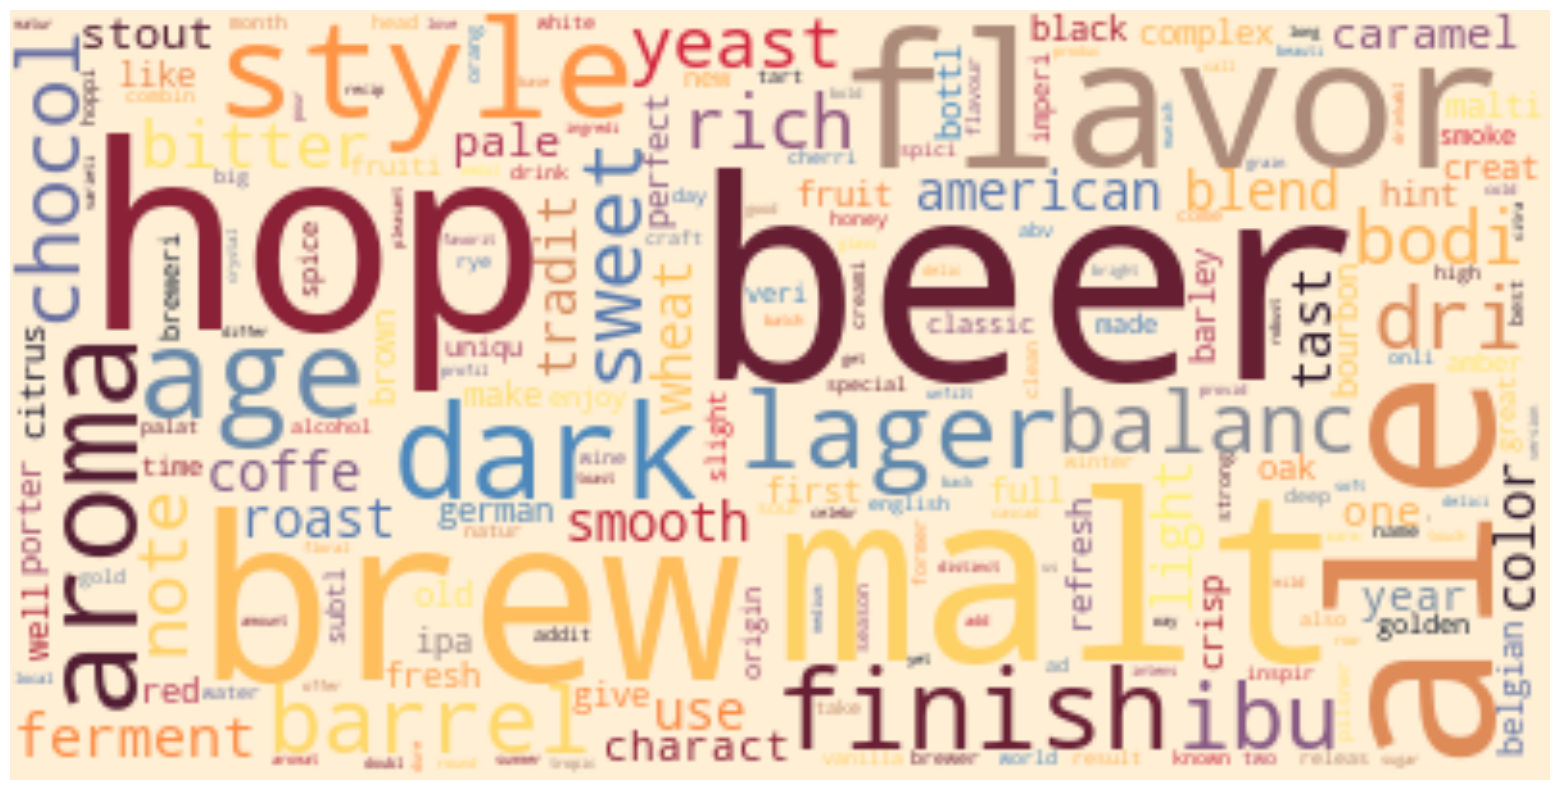

In [170]:
hero.wordcloud(text['clean_description'])

In [171]:
#inspecting top words
hero.top_words(text['clean_description'])[:10]

beer      2691
hop       2229
malt      1854
brew      1740
ale       1703
flavor    1188
style      813
dark       704
aroma      695
age        642
Name: clean_description, dtype: int64

> Unsurprisingly 'beer' is the most common word in the descriptions. As this would classify as a corpus specific stop words, they can be further filtered out using the max_df parameter in the Tf-idf vectorizer.

### Tfidf Vectorization

**TDIF EXPLAIN what is it and why i used it ***

As a first step, we will use TfidfVectorizer which will basically convert our ‘overview’ (a text column ) into numerical. All the data science models run on numerical values since computers can only understand 0s and 1s.

TF-IDF basically is Term Frequency-Inverse Document frequency. The number of features it creates is equal to the total number of distinct words used in the overview column and the values are directly proportional to the number of times a particular word is used and inversely proportional to the number of documents (movies here) in which the word is used. It will penalize a word even though a word has a huge number for a movie but is common to many movies. The words which occur multiple times but are common to many movies are anyways not so helpful in differentiating different movies.

In [172]:
# getting tfidf scores using sklearn Tfidf vectorizer
tf = TfidfVectorizer(min_df=0.005, max_df= 1500)
text_vec = tf.fit_transform(text.clean_description)

**Changing min & max df to account for corpus specific stop words**

**min_df** is used for removing terms that appear too infrequently. For example:

**min_df** = 0.01 means "ignore terms that appear in less than 1% of the documents". min_df = 5 means "ignore terms that appear in less than 5 documents". The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

> The number 0.005 was chosen after through an iterative process after reviewing the maxtrix that was created.

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:

**max_df** = 0.50 means "ignore terms that appear in more than 50% of the documents". max_df = 25 means "ignore terms that appear in more than 25 documents". The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

> After going through in iterative process, changing the max_df to ignore words that appear in more than 1500 documents has removed beer from being part of the matrix. However, it still includes other top words that describe beer such as malt, hop, and dark

In [173]:
vec = pd.DataFrame(text_vec.toarray(), columns=tf.get_feature_names(),index= text.index)
vec.head()

,19th,abbey,abund,abv,accent,accentu,accompani,accord,achiev,acid,...,wort,would,www,year,yeast,yellow,yet,yield,young,zest
beer_id,,,,,,,,,,,,,,,,,,,,,
251,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
252,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.104939,0.000000,0.0,0.000000,0.0,0.0,0.0
253,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.108784,0.0,0.157051,0.0,0.0,0.0
255,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
256,0.0,0.0,0.0,0.101863,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.081052,0.0,0.000000,0.0,0.0,0.0


In [174]:
vec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3346 entries, 251 to 700
Columns: 982 entries, 19th to zest
dtypes: float64(982)
memory usage: 25.1 MB


***
## Object and Numerical Preprocessing

### Read in data

In [175]:
df = pd.read_csv('../BeerData/tasting_cleaned.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,Name,beer_id,Style,Style Key,Brewery,Description,ABV,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,AvgIBU
0,Amber,251,Brown Ale,8,Alaskan Brewing Co.,"Richly malty and long on the palate, with just...",Medium,3.65,13,32,9,47,74,33,0,33,57,8,111,37.5
1,Double Bag,252,Brown Ale,8,Long Trail Brewing Co.,"This malty, full-bodied double alt is also kno...",Medium,3.90,12,57,18,33,55,16,0,24,35,12,84,37.5
2,Long Trail Ale,253,Brown Ale,8,Long Trail Brewing Co.,Long Trail Ale is a full-bodied amber ale mode...,Low,3.58,14,37,6,42,43,11,0,10,54,4,62,37.5
3,Scurry,255,Brown Ale,8,Off Color Brewing,Just cause it's dark and German doesn't mean i...,Medium,3.67,21,69,10,63,120,14,0,19,36,15,218,37.5
4,Sleigh'r Dark Doüble Alt Ale,256,Brown Ale,8,Ninkasi Brewing Company,Called 'Dark Double Alt' on the label.Seize th...,Medium,3.78,25,51,26,44,45,9,1,11,51,20,95,37.5


In [176]:
#beer_id will be used as a unique identifier for recommendations, not as an actual feature. 
# resetting index to be be unique_id so it is not preprocessed
df.set_index('beer_id', inplace=True)

#checking df
df.head(1)

,Name,Style,Style Key,Brewery,Description,ABV,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,AvgIBU
beer_id,,,,,,,,,,,,,,,,,,,
251,Amber,Brown Ale,8,Alaskan Brewing Co.,"Richly malty and long on the palate, with just...",Medium,3.65,13,32,9,47,74,33,0,33,57,8,111,37.5


> Columns to drop include: Name, Style Key, Brewery (in order to diversify recommendations), Description (text data will be rejoined after processing)

In [177]:
prepross = df.copy()

In [178]:
prepross.head()

,Name,Style,Style Key,Brewery,Description,ABV,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,AvgIBU
beer_id,,,,,,,,,,,,,,,,,,,
251,Amber,Brown Ale,8,Alaskan Brewing Co.,"Richly malty and long on the palate, with just...",Medium,3.65,13,32,9,47,74,33,0,33,57,8,111,37.5
252,Double Bag,Brown Ale,8,Long Trail Brewing Co.,"This malty, full-bodied double alt is also kno...",Medium,3.90,12,57,18,33,55,16,0,24,35,12,84,37.5
253,Long Trail Ale,Brown Ale,8,Long Trail Brewing Co.,Long Trail Ale is a full-bodied amber ale mode...,Low,3.58,14,37,6,42,43,11,0,10,54,4,62,37.5
255,Scurry,Brown Ale,8,Off Color Brewing,Just cause it's dark and German doesn't mean i...,Medium,3.67,21,69,10,63,120,14,0,19,36,15,218,37.5
256,Sleigh'r Dark Doüble Alt Ale,Brown Ale,8,Ninkasi Brewing Company,Called 'Dark Double Alt' on the label.Seize th...,Medium,3.78,25,51,26,44,45,9,1,11,51,20,95,37.5


In [179]:
prepross.drop(columns=['Name', 'Style Key', 'Brewery', 'Description'], inplace=True)

In [180]:
prepross.head()

,Style,ABV,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,AvgIBU
beer_id,,,,,,,,,,,,,,,
251,Brown Ale,Medium,3.65,13,32,9,47,74,33,0,33,57,8,111,37.5
252,Brown Ale,Medium,3.90,12,57,18,33,55,16,0,24,35,12,84,37.5
253,Brown Ale,Low,3.58,14,37,6,42,43,11,0,10,54,4,62,37.5
255,Brown Ale,Medium,3.67,21,69,10,63,120,14,0,19,36,15,218,37.5
256,Brown Ale,Medium,3.78,25,51,26,44,45,9,1,11,51,20,95,37.5


### Getting Dummy Variables for Object Features

In [181]:
prepross.dtypes
#will need to pull 'style' and 'abv'

Style           object
ABV             object
Avg Rating     float64
Astringency      int64
Body             int64
Alcohol          int64
Bitter           int64
Sweet            int64
Sour             int64
Salty            int64
Fruits           int64
Hoppy            int64
Spices           int64
Malty            int64
AvgIBU         float64
dtype: object

In [182]:
def object_process(df): 
    '''
    Function selects and transforms only category features.
    Returns a dataframe.
    '''
    cat = df.select_dtypes(include=['object'])
    dummies = pd.get_dummies(cat)
    return dummies

In [183]:
categories = object_process(prepross)
categories.head()

,Style_Bock,Style_Brown Ale,Style_Dark Ale,Style_Dark Lager,Style_Hybrid Beer,Style_India Pale Ale,Style_Pale Ale,Style_Pale Lager,Style_Porter,Style_Specialty Beer,Style_Stout,Style_Strong Ale,Style_Wheat Beer,Style_Wild/Sour Beer,Style_Wild/Sour Beers,ABV_High,ABV_Low,ABV_Medium
beer_id,,,,,,,,,,,,,,,,,,
251,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
252,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
253,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
255,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
256,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Scaling Numeric Features

In [184]:
# need to min max scale other columns
def numeric_process(df):
    '''
    Function selects and scales only numeric features.
    Returns a dataframe.
    '''
    num = df.select_dtypes(include=['int', 'float'])
    minmax = MinMaxScaler()
    scaled = minmax.fit_transform(num)
    scaled_model = pd.DataFrame(scaled, index = num.index, columns=num.columns)
    return scaled_model

In [185]:
numeric = numeric_process(prepross)

In [186]:
numeric.head()

,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,AvgIBU
beer_id,,,,,,,,,,,,,
251,0.646341,0.156627,0.162437,0.064748,0.313333,0.281369,0.102167,0.000000,0.148649,0.331395,0.043478,0.365132,0.454545
252,0.722561,0.144578,0.289340,0.129496,0.220000,0.209125,0.049536,0.000000,0.108108,0.203488,0.065217,0.276316,0.454545
253,0.625000,0.168675,0.187817,0.043165,0.280000,0.163498,0.034056,0.000000,0.045045,0.313953,0.021739,0.203947,0.454545
255,0.652439,0.253012,0.350254,0.071942,0.420000,0.456274,0.043344,0.000000,0.085586,0.209302,0.081522,0.717105,0.454545
256,0.685976,0.301205,0.258883,0.187050,0.293333,0.171103,0.027864,0.015625,0.049550,0.296512,0.108696,0.312500,0.454545


## Combining Transformed Data Frames
Combine the cleaned and transformed description matrix, categorical dummy variables, and the scaled numberical variables into one frame for modeling. 

In [187]:
#combining numeric and catetories first
model_df = numeric.merge(categories, left_index=True, right_index=True)

In [188]:
model_df.head()

,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,...,Style_Porter,Style_Specialty Beer,Style_Stout,Style_Strong Ale,Style_Wheat Beer,Style_Wild/Sour Beer,Style_Wild/Sour Beers,ABV_High,ABV_Low,ABV_Medium
beer_id,,,,,,,,,,,,,,,,,,,,,
251,0.646341,0.156627,0.162437,0.064748,0.313333,0.281369,0.102167,0.000000,0.148649,0.331395,...,0,0,0,0,0,0,0,0,0,1
252,0.722561,0.144578,0.289340,0.129496,0.220000,0.209125,0.049536,0.000000,0.108108,0.203488,...,0,0,0,0,0,0,0,0,0,1
253,0.625000,0.168675,0.187817,0.043165,0.280000,0.163498,0.034056,0.000000,0.045045,0.313953,...,0,0,0,0,0,0,0,0,1,0
255,0.652439,0.253012,0.350254,0.071942,0.420000,0.456274,0.043344,0.000000,0.085586,0.209302,...,0,0,0,0,0,0,0,0,0,1
256,0.685976,0.301205,0.258883,0.187050,0.293333,0.171103,0.027864,0.015625,0.049550,0.296512,...,0,0,0,0,0,0,0,0,0,1


In [189]:
#now adding description 
model_df = model_df.merge(vec, left_index=True, right_index=True)

In [190]:
model_df.head()

,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,...,wort,would,www,year,yeast,yellow,yet,yield,young,zest
beer_id,,,,,,,,,,,,,,,,,,,,,
251,0.646341,0.156627,0.162437,0.064748,0.313333,0.281369,0.102167,0.000000,0.148649,0.331395,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
252,0.722561,0.144578,0.289340,0.129496,0.220000,0.209125,0.049536,0.000000,0.108108,0.203488,...,0.0,0.0,0.0,0.104939,0.000000,0.0,0.000000,0.0,0.0,0.0
253,0.625000,0.168675,0.187817,0.043165,0.280000,0.163498,0.034056,0.000000,0.045045,0.313953,...,0.0,0.0,0.0,0.000000,0.108784,0.0,0.157051,0.0,0.0,0.0
255,0.652439,0.253012,0.350254,0.071942,0.420000,0.456274,0.043344,0.000000,0.085586,0.209302,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
256,0.685976,0.301205,0.258883,0.187050,0.293333,0.171103,0.027864,0.015625,0.049550,0.296512,...,0.0,0.0,0.0,0.000000,0.081052,0.0,0.000000,0.0,0.0,0.0


In [191]:
model_df.shape

(3346, 1013)

# Building Recommender

Creating meta data dataframe for use in displaying recommendations. It will display the name of the beer, the style, the brewery that made it, the description, the ABV, and the average rating of the beer.

In [210]:
df_meta_data = df.copy()

In [211]:
df_meta_data.drop(columns=['Style Key', 'Description', 'Astringency', 'Body', 'Alcohol',
                           'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits',
                           'Hoppy', 'Spices', 'Malty', 'AvgIBU'], inplace=True)
df_meta_data.head()

,Name,Style,Brewery,ABV,Avg Rating
beer_id,,,,,
251,Amber,Brown Ale,Alaskan Brewing Co.,Medium,3.65
252,Double Bag,Brown Ale,Long Trail Brewing Co.,Medium,3.90
253,Long Trail Ale,Brown Ale,Long Trail Brewing Co.,Low,3.58
255,Scurry,Brown Ale,Off Color Brewing,Medium,3.67
256,Sleigh'r Dark Doüble Alt Ale,Brown Ale,Ninkasi Brewing Company,Medium,3.78


### Model with Cosine Similarity

In [212]:
names_df = pd.DataFrame(df_meta_data.Name.value_counts())

In [213]:
dupenames = names_df.loc[names_df['Name'] > 1]
dupenames

,Name
Oktoberfest,14
Porter,8
Christmas Ale,7
Smoked Porter,6
Lager,6
...,...
Grodziskie,2
Berliner Weisse,2
Hard Root Beer,2
Robust Porter,2


In [214]:
df_meta_data.Name.duplicated().sum()

144

In [215]:
# # Input for name of beer that returns the 'beer_id' index number for 
# # the beer to be used to call dataframe
name = input('Name of beer: ')
beer = df_meta_data.index[df_meta_data['Name'] == name]
beer

Name of beer: Sculpin


Int64Index([1252], dtype='int64', name='beer_id')

In [216]:
y = np.array(model_df.loc[beer])
y = y.reshape(1,-1)
y

array([[0.87804878, 0.24096386, 0.17258883, ..., 0.        , 0.        ,
        0.        ]])

In [217]:
y.shape

(1, 1013)

In [218]:
# Calculating the similarity measures based on Cosine Similarity
cos_sim = cosine_similarity(model_df, y)
# Create a dataframe with similairty scores for each beer_id
cos_sim = pd.DataFrame(data=cos_sim, index = model_df.index)
cos_sim.head()

,0
beer_id,
251,0.532646
252,0.553384
253,0.313603
255,0.510909
256,0.530041


In [219]:
# Input used to ask how many recommendations the user would like returned
n_recs = int(input('How many recommendations? '))
# The cos_sim scores then need to be sorted in descending order to return top n number
cos_sim.sort_values(by = 0, ascending = False, inplace=True)
# In order to not return the original beer input first need to obtain the index values for the requested # of recommendations
results = cos_sim.index.values[1:n_recs+1]
results

How many recommendations? 5


array([1504, 1264, 1295, 1319, 1377])

In [220]:
results_df = df_meta_data.loc[results]
results_df.reset_index(inplace=True)
results_df

,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,1504,Enjoy By IPA,India Pale Ale,Stone Brewing,Medium,4.44
1,1264,Union Jack IPA,India Pale Ale,Firestone Walker Brewing Co.,Medium,4.24
2,1295,Hop Hunter,India Pale Ale,Sierra Nevada Brewing Co.,Medium,4.06
3,1319,The Audacity Of Hops,India Pale Ale,Cambridge Brewing Company,Medium,4.07
4,1377,Society & Solitude #2,India Pale Ale,Hill Farmstead Brewery,Medium,4.33


## Recommender Function
Combining code from above to make a function that will 

In [223]:
def beer_recommender(): 
    name = input('Name of beer: ')
    beer = df_meta_data.index[df_meta_data['Name'] == name]
    n_recs = int(input('How many recommendations? '))
    
    y = np.array(model_df.loc[beer]).reshape(1,-1)
    cos_sim = cosine_similarity(model_df, y)
    cos_sim = pd.DataFrame(data=cos_sim, index = model_df.index)
    cos_sim.sort_values(by = 0, ascending = False, inplace=True)
    results = cos_sim.index.values[1:n_recs+1]
    results_df = df_meta_data.loc[results]
    results_df.reset_index(inplace=True)
    return results_df

In [224]:
beer_recommender()

Name of beer: Shiner Bock
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,166,Schell's Bock,Bock,August Schell Brewing Company,Medium,3.89
1,103,Mardi Gras Bock,Bock,Abita Brewing Co.,Medium,3.48
2,486,After Dark,Brown Ale,Nelson Brewing Company,Low,3.68
3,4,Salvator,Bock,Paulaner Brauerei,Medium,3.95
4,187,Battlefield Bock,Bock,Red Oak Brewery,Medium,3.92


### Model with KNearestNeighbors

In [81]:
# Instaniate and fit the model using merged dataframe
knn = NearestNeighbors(n_neighbors=5)
knn.fit(model_df)

NearestNeighbors()

In [92]:
# results2 = knn.kneighbors(X=y, n_neighbors= 5,
#                           return_distance=False)